In [1]:
#import libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import sys
from scipy.spatial import ConvexHull

In [2]:
# galactic to equatorial conversion and vice-versa
def gal2eq_radians(lon,lat):
    '''
    duffett-smith
    
    https://archive.org/details/
    Practical_Astronomy_with_your_Calculator_or_Spreadsheet_4th_edition_by_Peter_Duf
    
    lon: 0 to 2 pi
    lat: -pi/2 to pi/2
    ra: 0 to 2 pi
    dec: -pi/2 to pi/2
    '''   
    l0=32.9320*np.pi/180.
    dec0=27.1284*np.pi/180.
    ra0=192.8595*np.pi/180.
    
    sindec = np.cos(lat) * np.cos(dec0) * np.sin(lon-l0) + np.sin(lat)*np.sin(dec0)
    #print sindec

    tanraprime_y = np.cos(lat) * np.cos(lon-l0)
    #print tanraprime_y
    
    tanraprime_x = np.sin(lat) * np.cos(dec0) - np.cos(lat) * np.sin(dec0) * np.sin(lon-l0)
    #print tanraprime_x
    
    #print tanraprime_y/tanraprime_x
    
    raprime = np.arctan2(tanraprime_y,tanraprime_x)
    #print raprime*180./np.pi
    
    ra=raprime+ra0
    ra = (ra + 2 * np.pi) % (2 * np.pi)
    
    #print ra*180./np.pi
    
    dec = np.arcsin(sindec)
    
    return ra,dec

def eq2gal_radians(ra,dec):
    '''
    duffett-smith
        
    https://archive.org/details/
    Practical_Astronomy_with_your_Calculator_or_Spreadsheet_4th_edition_by_Peter_Duf
    
    lon: 0 to 2 pi
    lat: -pi/2 to pi/2
    ra: 0 to 2 pi
    dec: -pi/2 to pi/2

    '''   
    l0=32.9320*np.pi/180.
    dec0=27.1284*np.pi/180.
    ra0=192.8595*np.pi/180.
    
    sinlat = np.sin(dec)*np.sin(dec0) + np.cos(dec) * np.cos(dec0) * np.cos(ra-ra0)
    #print sinlat

    tanlprime_y = np.sin(dec) - sinlat * np.sin(dec0)
    #print tanlprime_y
    
    tanlprime_x = np.cos(dec) * np.sin(ra-ra0)* np.cos(dec0)
    #print tanlprime_x
    
    #print tanlprime_y/tanlprime_x
    
    lprime = np.arctan2(tanlprime_y,tanlprime_x)
    #print lprime*180/np.pi
    
    lon=lprime+l0
    lon = (lon + 2 * np.pi) % (2 * np.pi)
    #print lon
    
    lat=np.arcsin(sinlat)
    
    return lon,lat

In [3]:
# icecube fov is costheta 1.0 to 0.8 and all azimuth.
# make arrays for declination and right ascension
# right ascension=azimuth (since we don't care about time here)
dec_resolution=100
ra_resolution=1000
ic_dec=[]
ic_ra=[]
for nd in np.linspace(0.,np.arccos(0.8),dec_resolution):
    for nr in np.linspace(0,2.*np.pi,ra_resolution):
        ic_ra.append(nr)
        ic_dec.append(nd-np.pi/2)

#convert to numpy arrays
ic_ra=np.array(ic_ra)
ic_dec=np.array(ic_dec)

(lonFOV,latFOV)=eq2gal_radians(ic_ra,ic_dec)

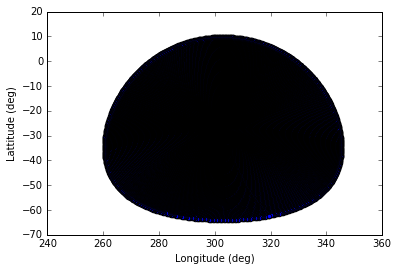

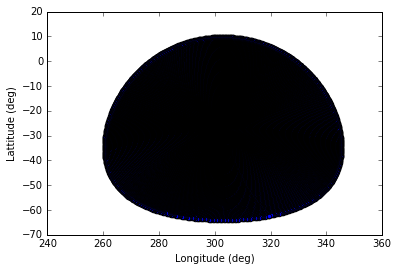

In [10]:
#plot the IceCube FOV in Galactic coordinates
plt.scatter(lonFOV*180/np.pi,latFOV*180/np.pi)
plt.xlabel('Longitude (deg)')
plt.ylabel('Lattitude (deg)')

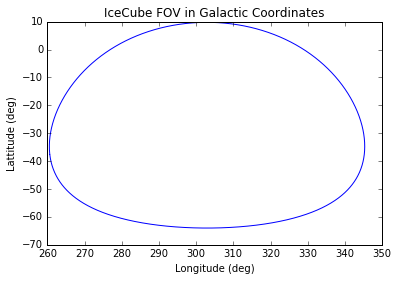

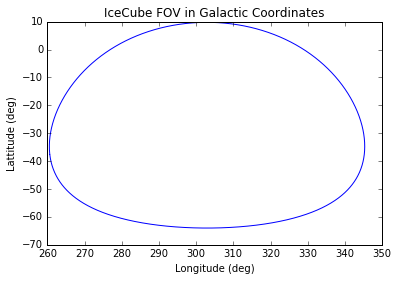

In [23]:
# ConvexHull gives the vertices that define the edge of this FOV
# in Galactic coordinates
points=np.array([[lonFOV[i],latFOV[i]] for i in range(len(lonFOV))])
hull = ConvexHull(points)

#plot the boundary of IceCube FOV in GC
plt.figure()
plt.plot(points[hull.vertices,0]*180/np.pi, points[hull.vertices,1]*180./np.pi)
plt.xlabel('Longitude (deg)')
plt.ylabel('Lattitude (deg)')
plt.title('IceCube FOV in Galactic Coordinates')

In [14]:
from mpl_toolkits.basemap import Basemap

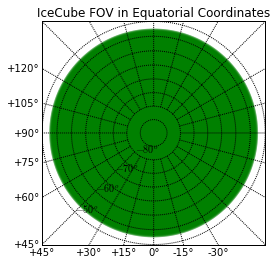

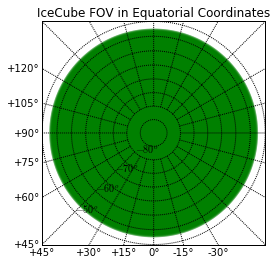

In [22]:
# IceCube FOV in Equatorial Coordinates
ra_reclaim,dec_reclaim=gal2eq_radians(lonFOV,latFOV)

#South Pole Projection
map1=Basemap(projection='spstere',boundinglat=-50,lon_0=0)

#Draw Grid Lines
map1.drawmeridians(np.arange(0,360,15), linewidth=1, labels=[1,0,0,1], labelstyle='+/-')
map1.drawparallels(np.arange(-90,-45,5), linewidth=1, labels=[0,0,0,0], labelstyle='+/-')

#Draw Grid Labels

x,y=map1(45,-80)
plt.text(x,y,r'$-80^{o}$')
x,y=map1(45,-70)
plt.text(x,y,r'$-70^{o}$')
x,y=map1(45,-60)
plt.text(x,y,r'$-60^{o}$')
x,y=map1(45,-50)
plt.text(x,y,r'$-50^{o}$')


x,y=map1(ra_reclaim*180./np.pi, dec_reclaim*180./np.pi)
sc=map1.scatter(x, y,c='g',alpha=0.2,edgecolor='None')
plt.title('IceCube FOV in Equatorial Coordinates')

In [24]:
def in_icecube_FOV(lon,lat):
    '''
    for a given lon, lat array of length N
    return a boolean array of length N 
    True: In icecube FOV
    FalsE: Not in icecube FOV
    
    This is for the Gamma ray analysis presented in ICRC
    https://pos.sissa.it/301/705/pdf
    '''
    ra,dec=gal2eq_radians(lon,lat)
    zenith=dec+np.pi/2.0
    bool_array=np.cos(zenith)>=0.8
    return bool_array

In [28]:
#test a point in IceCube FOV
in_icecube_FOV(300*np.pi/180.,-30*np.pi/180.)
#test a point in CASA-MIA FOV
in_icecube_FOV(75*np.pi/180.,-4*np.pi/180.)
#test a point in ARGO-YBJ FOV
in_icecube_FOV(40*np.pi/180.,2*np.pi/180.)

False

False